In [4]:
from causalml.inference.meta import BaseSLearner, BaseTLearner, BaseXLearner
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
# from causalml.dataset import synthetic_data
import numpy as np
from dataloader import load_IHDP_data
from visualizations import plot_cates_uber, plot_cates
from causalml.metrics import *
from matplotlib import pyplot as plt 
import seaborn as sns
import pandas as pd

data = load_IHDP_data(training_data='./ihdp_npci_1-100.train.npz',testing_data='./ihdp_npci_1-100.test.npz')

#concatenate t so we can use it as input
xt = np.concatenate([data['x'], data['t']], 1)

X = data['x']
z = data['t'].reshape(-1)
y = data['y'].reshape(-1)

ite = data['mu_1'] - data['mu_0']


In [5]:
def get_metrics(name, model):
    pred = model.fit_predict(X, z, y).reshape(-1)
    try:
        ate, lb, ub = model.estimate_ate(X, z, y, return_ci=True) #95% CI
    except:
        ate, lb, ub = model.estimate_ate(X, z, y)
    mad_metric = abs(ate - np.mean(ite))
    pehe = rmse(pred, ite)
    return (pred, [name, pehe, mad_metric[0], lb[0], ub[0]])

#### S-Learner OLS

Using a classical linear regression model to estimate ATE is standard, but using it to estimate CATE is problematic. While the ATE may be accurate when estimating using linear regression, the CATE under linear regression is equal to the ATE for all units. Intuitively, we should expect units with a particular set of features to have a different CATE compared to units with a different set of features. In reality, it is naive to assume a treatment treats all units in the exact same manner and here in lies the inspiration for more powerful machine learning techniques to acurately estimate the heterogenous effect of individual units. 

In [7]:
import pandas as pd
ols = BaseSLearner(learner=LinearRegression())


cate_ols_outcome, slearner_ols_results = get_metrics("S Learner (LR)", ols)

In [8]:
results = ols.predict(X, z, y, return_components=True)
cate = results[0]
pred = results[1]

(747,)

In [65]:
def get_rmse(y0, y1):
    control_indicies = np.where(z == 0)[0]
    treatment_indicies = np.where(z == 1)[0]
    
    control_losses = (y[control_indicies] - y0[control_indicies])
    treatment_losses = (y[treatment_indicies] - y1[treatment_indicies])

    return np.sqrt(np.mean(np.concatenate((control_losses,treatment_losses))**2))


In [66]:
y0 = results[1][1]
y1 = results[2][1]
get_rmse(y0, y1)

1.3304864777234495

In [53]:
slearner_ols_results

['S Learner (LR)',
 1.5418028634501457,
 0.09343173886379663,
 3.669330693081139,
 4.224839646523896]

#### S-Learner MLP

The next approach follows from modern day deep learning techniques and uses a multilayer perceptron as the basis for our S-Learner. Best hyperparameters:
* lr=0.1000, layers=5, neurons=20

In [92]:
layer_smlp = [20 for i in np.arange(5)]

s_mlp = BaseSLearner(learner=MLPRegressor(hidden_layer_sizes = layer_smlp,learning_rate_init=0.1, batch_size=64, max_iter=3000, random_state=42))
cate_s_mlp_outcome, slearner_mlp_results = get_metrics("S Learner (MLP)", s_mlp)
slearner_mlp_results

['S Learner (MLP)',
 1.0931660431657122,
 0.4584432983201374,
 3.2055067843604457,
 3.584913480876721]

In [84]:
results_smlp = s_mlp.predict(X, z, y, return_components=True)
smlp_y0 = results_smlp[1][1]
smlp_y1 = results_smlp[2][1]
rmse_smlp = get_rmse(smlp_y0, smlp_y1)
rmse_smlp

0.9686321087257812

In [ ]:
for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    plt.plot((lower,upper),(y,y),'ro-',color='orange')
plt.yticks(range(len(dataset)),list(dataset['category']))

##### Hyperparameter Tuning

In [21]:
# lrs= [1e-1, 1e-2, 1e-3, 1e-4]
# num_hidden_layers = [1,3,5,7]
# hidden_layer_sizes = [20,50,100]
# data = []
# for lr in lrs:
#     for layer in num_hidden_layers:
#         for sizes in hidden_layer_sizes:
#             layer_dims = [sizes for i in np.arange(layer)]
#             s_mlp = BaseSLearner(learner=MLPRegressor(hidden_layer_sizes=layer_dims, batch_size=64, max_iter=1000, learning_rate_init=lr))
#             cate_s_mlp_outcome, slearner_mlp_results = get_metrics("S Learner (MLP)", s_mlp)
#             print(lr, layer, sizes)
#             data.append(slearner_mlp_results + [lr, layer, sizes])


# hyper_results_s_mlp = pd.DataFrame(data=data, 
# columns= ["Learner", "PEHE", "Mean Abs Diff (ATE)", "LB", "UB", "lr", "layers", "hidden_dim"])
# hyper_results_s_mlp.sort_values(by='PEHE').head(5)

# hyper_results_s_mlp.sort_values(by='Mean Abs Diff (ATE)').head(5)


#### T-Learner MLP
Best Hyperparameters:
* lr=0.0001, layers=7, neurons=20

In [112]:
# lr=0.1000,layer=7, neurons=20
layer_t = [20 for i in np.arange(7)]
t_mlp = BaseTLearner(control_learner=MLPRegressor(hidden_layer_sizes=layer_t, learning_rate_init=0.0001, batch_size=64, max_iter=3000, random_state=42), 
treatment_learner=MLPRegressor(hidden_layer_sizes=layer_t, learning_rate_init=0.0001, batch_size=64, max_iter=3000, random_state=42))

cate_t_mlp_outcome, tlearner_mlp_results = get_metrics("T Learner (MLP)", t_mlp)
tlearner_mlp_results

# ate, lb, ub = t_mlp.estimate_ate(X, z, y)
# print("Average Treatment Effect (True = %2f): %2f" % (np.average(data['mu_1']-data['mu_0']), ate))
# print("Confidence Interval (CI): %2f, %2f " % (lb, ub))

['T Learner (MLP)',
 1.5334767379609229,
 0.01409277858504332,
 3.694179416458043,
 4.041313002589486]

In [97]:
results_tmlp = t_mlp.predict(X, z, y, return_components=True)
tmlp_y0 = results_tmlp[1][1]
tmlp_y1 = results_tmlp[2][1]
rmse_tmlp = get_rmse(tmlp_y0, tmlp_y1)
rmse_tmlp

2.2057872

In [19]:
# lrs= [1e-1, 1e-2, 1e-3, 1e-4]
# num_hidden_layers = [1,3,5,7]
# hidden_layer_sizes = [20,50,100]

# t_hyper_data = []
# for lr in lrs:
#     for layer in num_hidden_layers:
#         for sizes in hidden_layer_sizes:
#             layer_dims = [sizes for i in np.arange(layer)]
#             t_mlp = BaseTLearner(learner=MLPRegressor(hidden_layer_sizes=layer_dims, batch_size=64, max_iter=1000, learning_rate_init=lr))
#             cate_t_mlp_outcome, tlearner_mlp_results = get_metrics("T Learner (MLP)", t_mlp)
#             print(lr, layer, sizes)
#             t_hyper_data.append(tlearner_mlp_results + [lr, layer, sizes])

# hyper_results_t_mlp = pd.DataFrame(data=t_hyper_data, 
# columns= ["Learner", "PEHE", "Mean Abs Diff (ATE)", "LB", "UB", "lr", "layers", "hidden_dim"])
# hyper_results_t_mlp.sort_values(by='PEHE').head(5)

# hyper_results_t_mlp.sort_values(by='Mean Abs Diff (ATE)').head(5)

In [114]:
layer_t = [20 for i in np.arange(7)]
t_mlp_lr = BaseTLearner(control_learner=MLPRegressor(hidden_layer_sizes=layer_t, learning_rate_init=0.0001, batch_size=64, max_iter=3000, random_state=42), 
treatment_learner=LinearRegression())

cate_t_mlp_lr_outcome, t_mlp_lr_results = get_metrics("T Learner (MLP, LR)", t_mlp_lr)
t_mlp_lr_results

['T Learner (MLP, LR)',
 1.2085886669590933,
 0.16982216656287852,
 3.463981401303067,
 3.903681127448617]

In [115]:
layer_t = [20 for i in np.arange(7)]
t_lr_mlp = BaseTLearner(treatment_learner=MLPRegressor(hidden_layer_sizes=layer_t, learning_rate_init=0.0001, batch_size=64, max_iter=3000, random_state=42), 
control_learner=LinearRegression())

cate_t_lr_mlp_outcome, t_lr_mlp_results = get_metrics("T Learner (LR, MLP)", t_lr_mlp)
t_lr_mlp_results

['T Learner (LR, MLP)',
 1.3219247683972666,
 0.010221918902722837,
 3.686482381796486,
 4.041268317886401]

#### X-Learner

After running through a grid search for hyper parameter tuning, using a learning rate of 1e-4, 5 layers, and 20 neurons per layer was optimal in minimizing PEHE, our most valued statistic for CATE. Even though this particular combination did not have the best estimate for ATE, our focus on CATE is what makes this particular model most meaningful. Best hyperparameters:
* lr=0.0001, layers=5, neurons=20

In general, the best model for PEHE did not estimate ATE the best. The ATE was close, but for other choices of hyperparameters the ATE estimation was better. When looking at a real world dataset where the PEHE is unknown, this information is important as just because we get a good estimation for the ATE does not mean that PEHE is optimal. Ultimately PEHE tells us more about our within difference error which is critical for highly accurate CATE.

In [86]:
%%capture 
layer = [20 for i in np.arange(5)]
x_mlp = BaseXLearner(learner=MLPRegressor(hidden_layer_sizes=layer, batch_size=64, learning_rate_init=1e-4, max_iter=2000,activation="relu", random_state=42))
cate_x_mlp_outcome, xlearner_mlp_results = get_metrics("X Learner (MLP)", x_mlp)

In [117]:
%%capture 
layer = [20 for i in np.arange(5)]
x_mlp_regressor = MLPRegressor(hidden_layer_sizes=layer, batch_size=64, learning_rate_init=1e-4, max_iter=2000,activation="relu", random_state=42)
x_mlp_lr = BaseXLearner(control_outcome_learner=x_mlp_regressor,
treatment_outcome_learner=LinearRegression(), control_effect_learner=x_mlp_regressor, treatment_effect_learner=x_mlp_regressor)
cate_x_mlp_lr_outcome, x_mlp_lr_results = get_metrics("X Learner (MLP, LR)", x_mlp_lr)
x_mlp_lr_results

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

['X Learner (MLP, LR)',
 1.5136467225958254,
 0.051691309928889595,
 3.6941552373934736,
 4.1165342443417465]

In [118]:
%%capture 
layer = [20 for i in np.arange(5)]
x_mlp_regressor = MLPRegressor(hidden_layer_sizes=layer, batch_size=64, learning_rate_init=1e-4, max_iter=2000,activation="relu", random_state=42)
x_lr_mlp = BaseXLearner(treatment_outcome_learner=x_mlp_regressor,
control_outcome_learner=LinearRegression(), control_effect_learner=x_mlp_regressor, treatment_effect_learner=x_mlp_regressor)
cate_x_lr_mlp_outcome, x_lr_mlp_results = get_metrics("X Learner (LR, MLP)", x_lr_mlp)
x_lr_mlp_results

In [87]:
results_xmlp = x_mlp.predict(X, z, y, return_components=True)
xmlp_y0 = results_xmlp[1][1]
xmlp_y1 = results_xmlp[2][1]
rmse_xmlp = get_rmse(xmlp_y0, xmlp_y1)
rmse_xmlp

4.429282

In [119]:
x_lr_mlp_results

['X Learner (LR, MLP)',
 1.35789737813518,
 0.2770435355174481,
 3.944386918376447,
 4.317007014535891]

In [20]:
# %%capture 

# x_hyper_data = []
# for lr in lrs:
#     for layer in num_hidden_layers:
#         for sizes in hidden_layer_sizes:
#             layer_dims = [sizes for i in np.arange(layer)]
#             x_mlp = BaseXLearner(learner=MLPRegressor(hidden_layer_sizes=layer_dims, batch_size=64, max_iter=1000, learning_rate_init=lr))
#             cate_x_mlp_outcome, xlearner_mlp_results = get_metrics("X Learner (MLP)", x_mlp)
#             print(lr, layer, sizes)
#             x_hyper_data.append(xlearner_mlp_results + [lr, layer, sizes])

# hyper_results_x_mlp = pd.DataFrame(data=x_hyper_data, 
# columns= ["Learner", "PEHE", "Mean Abs Diff (ATE)", "LB", "UB", "lr", "layers", "hidden_dim"])
# hyper_results_x_mlp.sort_values(by='PEHE').head(5)
# hyper_results_x_mlp.sort_values(by='Mean Abs Diff (ATE)').head(5)

#### Results

In [126]:
results = pd.DataFrame(data=[slearner_ols_results, slearner_mlp_results, tlearner_mlp_results, t_mlp_lr_results, t_lr_mlp_results, xlearner_mlp_results, x_lr_mlp_results, x_mlp_lr_results], 
columns= ["Learner", "PEHE", "Mean Abs Diff (ATE)", "LB", "UB"])
results.sort_values(by='PEHE')
# results.to_csv("learner_results.csv")

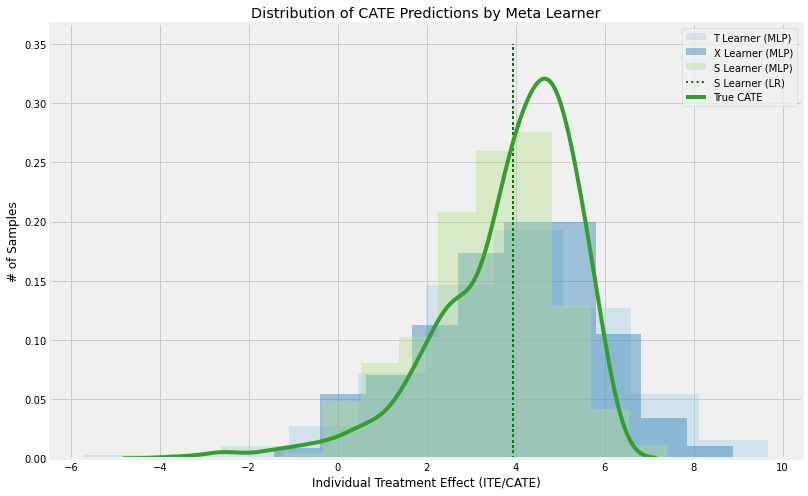

In [127]:
alpha=0.4
plt.figure(figsize=(12,8))
plt.hist(cate_t_mlp_outcome, alpha=alpha, label='T Learner (MLP)', density=True)
plt.hist(cate_x_mlp_outcome,alpha=alpha, label='X Learner (MLP)',  density=True)
plt.hist(cate_s_mlp_outcome,alpha=alpha, label='S Learner (MLP)',  density=True)
plt.vlines(cate_ols_outcome, 0, 0.35, label='S Learner (LR)',
           linestyles='dotted', colors='green', linewidth=2)
sns.kdeplot(ite, label="True CATE")
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()
plt.savefig("ite_ihdp.png")
